In [ ]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch


import random
np.random.seed(42)
random.seed(42)
!pip install xgboost
!pip install catboost lightgbm
!pip install shap


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import os
os.environ['OMP_NUM_THREADS'] = '1'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [ ]:
!pip install tabpfn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# Importing the dataset
bank_data = pd.read_csv('churn.csv')

In [ ]:
bank_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
#Dropping columns not useful for analysis
bank_data = bank_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Display the first few rows to verify the changes
bank_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
#ENCODING CATEGORICAL VARIABLES
# Label Encoding for 'Gender'
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
label_encoder = LabelEncoder()
bank_data["Gender"] = label_encoder.fit_transform(bank_data["Gender"])  # Female = 0, Male = 1

# One-Hot Encoding for 'Geography'
one_hot_encoder = OneHotEncoder(sparse_output=False)
geo_encoded1 = one_hot_encoder.fit_transform(bank_data[["Geography"]])
bank_data_encoded = pd.get_dummies(bank_data, drop_first=True)

# FEATURE SELECTION

In [ ]:
#Determining input and target variable
A = bank_data_encoded.drop(columns=['Exited'])
B = bank_data_encoded['Exited']

In [ ]:
#Apply SelectKBest on all variables
from sklearn.feature_selection import SelectKBest, mutual_info_classif
feature_selector = SelectKBest(score_func=lambda X, y: mutual_info_classif(X, y, random_state=42), k=8)
A_selected = feature_selector.fit_transform(A, B)

#Get the names of the selected features
selected_features = A.columns[feature_selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'Geography_Germany'],
      dtype='object')


In [ ]:
#Scale only the selected features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
A_selected_scaled = scaler.fit_transform(A[selected_features])

A_selected_scaled

array([[-1.09598752,  0.29351742, -1.04175968, ...,  0.64609167,
         0.97024255, -0.57873591],
       [-1.09598752,  0.19816383, -1.38753759, ..., -1.54776799,
         0.97024255, -0.57873591],
       [-1.09598752,  0.29351742,  1.03290776, ...,  0.64609167,
        -1.03067011, -0.57873591],
       ...,
       [-1.09598752, -0.27860412,  0.68712986, ..., -1.54776799,
         0.97024255, -0.57873591],
       [ 0.91241915,  0.29351742, -0.69598177, ...,  0.64609167,
        -1.03067011,  1.72790383],
       [-1.09598752, -1.04143285, -0.35020386, ...,  0.64609167,
        -1.03067011, -0.57873591]])

#ADDRESSING CLASS IMBALANCE

In [ ]:
#Splitting data to train and test sets
from sklearn.model_selection import train_test_split
A_train, A_test, B_train, B_test = train_test_split(A_selected, B, test_size=0.2, random_state=42, stratify=B)

<Axes: xlabel='Exited', ylabel='count'>

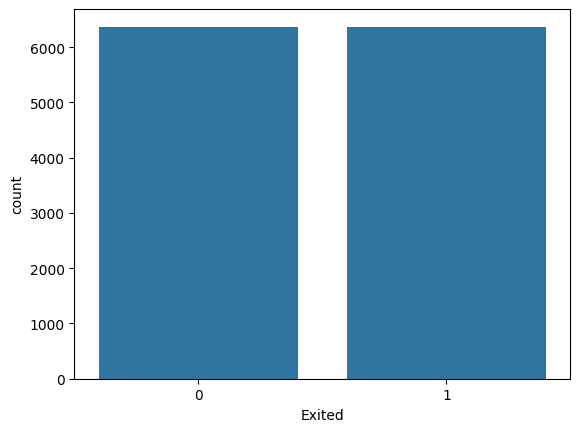

In [ ]:
#Performing oversampling using SMOTE
from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state=0)
A_train_smote, B_train_smote = resampler.fit_resample(A_train, B_train)

sns.countplot(x=B_train_smote)

In [ ]:
#checking class distribution after SMOTE
print("Class Distribution After SMOTE:")
print(B_train_smote.value_counts(normalize=True))

Class Distribution After SMOTE:
Exited
1    0.5
0    0.5
Name: proportion, dtype: float64


In [ ]:
#BUILDING XGBOOST MODEL
from xgboost import XGBClassifier

# Initialize XGBoost with scale_pos_weight to balance churned class
xgb_model = XGBClassifier(scale_pos_weight=3, random_state=42)

# Train model
xgb_model.fit(A_train_smote, B_train_smote)

# Predict on test data
B_pred_xgb = xgb_model.predict(A_test)
print(B_pred_xgb)

[0 0 0 ... 1 0 0]


In [ ]:
#To print real value of labels in test dataset
print(B_test)

5702    0
3667    0
1617    0
5673    0
4272    0
       ..
5768    0
833     0
9719    1
2776    0
3776    0
Name: Exited, Length: 2000, dtype: int64


In [ ]:
#To evaluate the performance of model
from sklearn import metrics
acc=metrics.accuracy_score(B_test,B_pred_xgb)
print('accuracy:%.2f\n\n'%(acc))
cm=metrics.confusion_matrix(B_test,B_pred_xgb)
print('Confusion Matrix:')
print(cm,'\n\n')
print('-----------------------------------------------------')
result=metrics.classification_report(B_test,B_pred_xgb)
print('Classification Report:\n')
print(result)

accuracy:0.82


Confusion Matrix:
[[1370  223]
 [ 129  278]] 


-----------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1593
           1       0.55      0.68      0.61       407

    accuracy                           0.82      2000
   macro avg       0.73      0.77      0.75      2000
weighted avg       0.84      0.82      0.83      2000



In [ ]:
#HYPERPARAMETER TUNING OF XGBOOST MODEL
from sklearn.model_selection import GridSearchCV
# Define hyperparameter grid
xgb_params = {
    "n_estimators": [100, 300, 500],  # Number of trees
    "learning_rate": [0.01, 0.1, 0.2],  # Learning rate (step size)
    "max_depth": [3, 5, 7],  # Tree depth
    "scale_pos_weight": [2, 2.5, 3]  # Adjusting for class imbalance
}

# Perform Grid Search
xgb_grid = GridSearchCV(XGBClassifier(random_state=42), xgb_params, cv=3, scoring="f1", n_jobs=-1)
xgb_grid.fit(A_train_smote, B_train_smote)

# Print best parameters
print("Best XGBoost Parameters:", xgb_grid.best_params_)

Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'scale_pos_weight': 2}


In [ ]:
# Train final XGBoost model with best parameters
best_xgb_model = XGBClassifier(**xgb_grid.best_params_, random_state=42)
best_xgb_model.fit(A_train_smote, B_train_smote)

# Predict on test data
B_pred_xgb_tuned = best_xgb_model.predict(A_test)
print(B_pred_xgb_tuned)

[0 0 0 ... 1 0 0]


In [ ]:
#To evaluate the performance of model
from sklearn import metrics
acc=metrics.accuracy_score(B_test,B_pred_xgb_tuned)
print('accuracy:%.2f\n\n'%(acc))
cm=metrics.confusion_matrix(B_test,B_pred_xgb_tuned)
print('Confusion Matrix:')
print(cm,'\n\n')
print('-----------------------------------------------------')
result=metrics.classification_report(B_test,B_pred_xgb_tuned)
print('Classification Report:\n')
print(result)

accuracy:0.82


Confusion Matrix:
[[1347  246]
 [ 120  287]] 


-----------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1593
           1       0.54      0.71      0.61       407

    accuracy                           0.82      2000
   macro avg       0.73      0.78      0.75      2000
weighted avg       0.84      0.82      0.83      2000



In [ ]:
#BUILDING STACK MODEL
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Define base models with improvements
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)),  # Class balancing
    ('xgb', XGBClassifier(n_estimators=100, scale_pos_weight=3, random_state=42)),  # Handles imbalance
    ('catboost', CatBoostClassifier(verbose=0, random_state=42)),
    ('lightgbm', LGBMClassifier(n_estimators=100, random_state=42))
]

# Define meta-model (final estimator) with class balancing
meta_model = LogisticRegression(class_weight="balanced", random_state=42)

# Create stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train the stacking model on the SMOTE-balanced data
stacking_model.fit(A_train_smote, B_train_smote)

# Predict on test data
B_pred_stack = stacking_model.predict(A_test)
print(B_pred_stack)

[LightGBM] [Info] Number of positive: 6370, number of negative: 6370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5096, number of negative: 5096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2038
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5096, number of negative: 5096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

In [ ]:
#To evaluate the performance of model
from sklearn import metrics
acc=metrics.accuracy_score(B_test,B_pred_stack)
print('accuracy:%.2f\n\n'%(acc))
cm=metrics.confusion_matrix(B_test,B_pred_stack)
print('Confusion Matrix:')
print(cm,'\n\n')
print('-----------------------------------------------------')
result=metrics.classification_report(B_test,B_pred_stack)
print('Classification Report:\n')
print(result)

accuracy:0.86


Confusion Matrix:
[[1494   99]
 [ 185  222]] 


-----------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1593
           1       0.69      0.55      0.61       407

    accuracy                           0.86      2000
   macro avg       0.79      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



In [ ]:
#HYPERPARAMETER TUNING FOR STACK MODEL
# Define hyperparameter grids for base models
rf_params = {
    "n_estimators": [100, 300],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5]
}

xgb_params = {
    "n_estimators": [100, 300],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5]
}

catboost_params = {
    "iterations": [100, 200],
    "learning_rate": [0.05, 0.1],
    "depth": [6, 10]
}

lgbm_params = {
    "n_estimators": [100, 300],
    "learning_rate": [0.01, 0.1],
    "num_leaves": [31, 50]
}

# Tune Random Forest
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring="f1", n_jobs=-1)
rf_grid.fit(A_train_smote, B_train_smote)
print("Best RF Params:", rf_grid.best_params_)

# Tune XGBoost
xgb_grid = GridSearchCV(XGBClassifier(random_state=42), xgb_params, cv=3, scoring="f1", n_jobs=-1)
xgb_grid.fit(A_train_smote, B_train_smote)
print("Best XGB Params:", xgb_grid.best_params_)

# Tune CatBoost
catboost_grid = GridSearchCV(CatBoostClassifier(verbose=0, random_state=42), catboost_params, cv=3, scoring="f1", n_jobs=-1)
catboost_grid.fit(A_train_smote, B_train_smote)
print("Best CatBoost Params:", catboost_grid.best_params_)

# Tune LightGBM
lgbm_grid = GridSearchCV(LGBMClassifier(random_state=42), lgbm_params, cv=3, scoring="f1", n_jobs=-1)
lgbm_grid.fit(A_train_smote, B_train_smote)
print("Best LGBM Params:", lgbm_grid.best_params_)

Best RF Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Best XGB Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best CatBoost Params: {'depth': 6, 'iterations': 100, 'learning_rate': 0.05}
[LightGBM] [Info] Number of positive: 6370, number of negative: 6370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best LGBM Params: {'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 31}


In [ ]:
# Define base models with best hyperparameters
base_models = [
    ('rf', RandomForestClassifier(**rf_grid.best_params_, random_state=42)),
    ('xgb', XGBClassifier(**xgb_grid.best_params_, random_state=42)),
    ('catboost', CatBoostClassifier(**catboost_grid.best_params_, verbose=0, random_state=42)),
    ('lightgbm', LGBMClassifier(**lgbm_grid.best_params_, random_state=42))
]

# Define meta-model (final estimator) with class balancing
meta_model = LogisticRegression(class_weight="balanced", random_state=42)

# Create stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train the stacking model on the SMOTE-balanced data
stacking_model.fit(A_train_smote, B_train_smote)

# Predict the stacking model on test data
B_pred_stack_tuned = stacking_model.predict(A_test)
print(B_pred_stack_tuned)

[LightGBM] [Info] Number of positive: 6370, number of negative: 6370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5096, number of negative: 5096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2038
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5096, number of negative: 

In [ ]:
#To evaluate the performance of model
from sklearn import metrics
acc=metrics.accuracy_score(B_test,B_pred_stack_tuned)
print('accuracy:%.2f\n\n'%(acc))
cm=metrics.confusion_matrix(B_test,B_pred_stack_tuned)
print('Confusion Matrix:')
print(cm,'\n\n')
print('-----------------------------------------------------')
result=metrics.classification_report(B_test,B_pred_stack_tuned)
print('Classification Report:\n')
print(result)

accuracy:0.85


Confusion Matrix:
[[1475  118]
 [ 177  230]] 


-----------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.66      0.57      0.61       407

    accuracy                           0.85      2000
   macro avg       0.78      0.75      0.76      2000
weighted avg       0.85      0.85      0.85      2000



In [ ]:
#BUILDING TABPFN MODEL
from tabpfn import TabPFNClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Confirm GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [ ]:
# Initialize the TabPFN classifier
model = TabPFNClassifier(device=device)

# Fit the model
model.fit(A_train, B_train.astype(int))

# Predict
B_pred = model.predict(A_test)

# Evaluation
print("TabPFN Performance:")
print("Accuracy:", accuracy_score(B_test, B_pred))
print("Classification Report:")
print(classification_report(B_test, B_pred))
print("Confusion Matrix:")
print(confusion_matrix(B_test, B_pred))

tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN Performance:
Accuracy: 0.871
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1593
           1       0.78      0.51      0.62       407

    accuracy                           0.87      2000
   macro avg       0.83      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000

Confusion Matrix:
[[1534   59]
 [ 199  208]]


In [ ]:
#Adjusting decision threshold in TabPFN
#Get predicted probabilities instead of labels
probs = model.predict_proba(A_test)  # Shape: (n_samples, n_classes)

#Pick a custom threshold
threshold = 0.3

#Apply the threshold manually
B_pred_thresh = (probs[:, 1] >= threshold).astype(int)

#Evaluate the performance
print("TabPFN Performance with Threshold =", threshold)
print("Accuracy:", accuracy_score(B_test, B_pred_thresh))
print("Classification Report:")
print(classification_report(B_test, B_pred_thresh))
print("Confusion Matrix:")
print(confusion_matrix(B_test, B_pred_thresh))

TabPFN Performance with Threshold = 0.3
Accuracy: 0.854
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1593
           1       0.64      0.65      0.64       407

    accuracy                           0.85      2000
   macro avg       0.77      0.78      0.78      2000
weighted avg       0.85      0.85      0.85      2000

Confusion Matrix:
[[1444  149]
 [ 143  264]]


In [ ]:
#MANUAL BLENDING(XGBOOST+TABPFN)
#from tabpfn import TabPFNClassifier

tabpfnmodel2 = TabPFNClassifier(device=device)

xgbmodel3 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


tabpfnmodel2.fit(A_train, B_train.astype(int))
xgbmodel3.fit(A_train, B_train.astype(int))


# Get predicted probabilities
tabpfn_probs = tabpfnmodel2.predict_proba(A_test)
xgb_probs = xgbmodel3.predict_proba(A_test)

# Blend predictions (e.g., 30% XGBoost, 70% TabPFN)
blended_probs = 0.3 * xgb_probs + 0.7 * tabpfn_probs

# Apply threshold
threshold = 0.3
B_pred_blended = (blended_probs[:, 1] >= threshold).astype(int)

# Evaluate
print("Blended Model Performance")
print("Accuracy:", accuracy_score(B_test, B_pred_blended))
print("Classification Report:")
print(classification_report(B_test, B_pred_blended))
print("Confusion Matrix:")
print(confusion_matrix(B_test, B_pred_blended))

Blended Model Performance
Accuracy: 0.852
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1593
           1       0.63      0.66      0.65       407

    accuracy                           0.85      2000
   macro avg       0.77      0.78      0.78      2000
weighted avg       0.86      0.85      0.85      2000

Confusion Matrix:
[[1434  159]
 [ 137  270]]


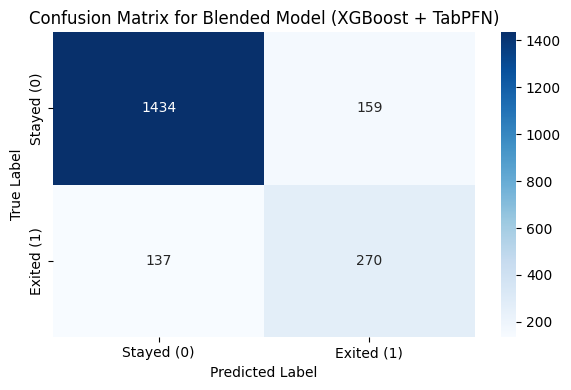

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(B_test, B_pred_blended)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Stayed (0)", "Exited (1)"], yticklabels=["Stayed (0)", "Exited (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Blended Model (XGBoost + TabPFN)")
plt.tight_layout()
plt.show()

In [ ]:
# Creating a table for model results
model_results = pd.DataFrame({
    'Model': [
        'XGBoost',
        'XGBoost (Tuned)',
        'Stacked',
        'Stacked (Tuned)',
        'TabPFN',
        'TabPFN (Thresh=0.3)',
        'Blended (XGB+TabPFN)'
    ],
    'Accuracy': [0.82, 0.82, 0.86, 0.85, 0.871, 0.854, 0.852],
    'Precision_Churn': [0.55, 0.54, 0.69, 0.66, 0.78, 0.64, 0.63],
    'Recall_Churn': [0.68, 0.71, 0.55, 0.57, 0.51, 0.65, 0.66],
    'F1_Churn': [0.61, 0.61, 0.61, 0.61, 0.62, 0.65, 0.65]
})

display(model_results)

,Model,Accuracy,Precision_Churn,Recall_Churn,F1_Churn
0,XGBoost,0.820,0.55,0.68,0.61
1,XGBoost (Tuned),0.820,0.54,0.71,0.61
2,Stacked,0.860,0.69,0.55,0.61
3,Stacked (Tuned),0.850,0.66,0.57,0.61
4,TabPFN,0.871,0.78,0.51,0.62
5,TabPFN (Thresh=0.3),0.854,0.64,0.65,0.65
6,Blended (XGB+TabPFN),0.852,0.63,0.66,0.65


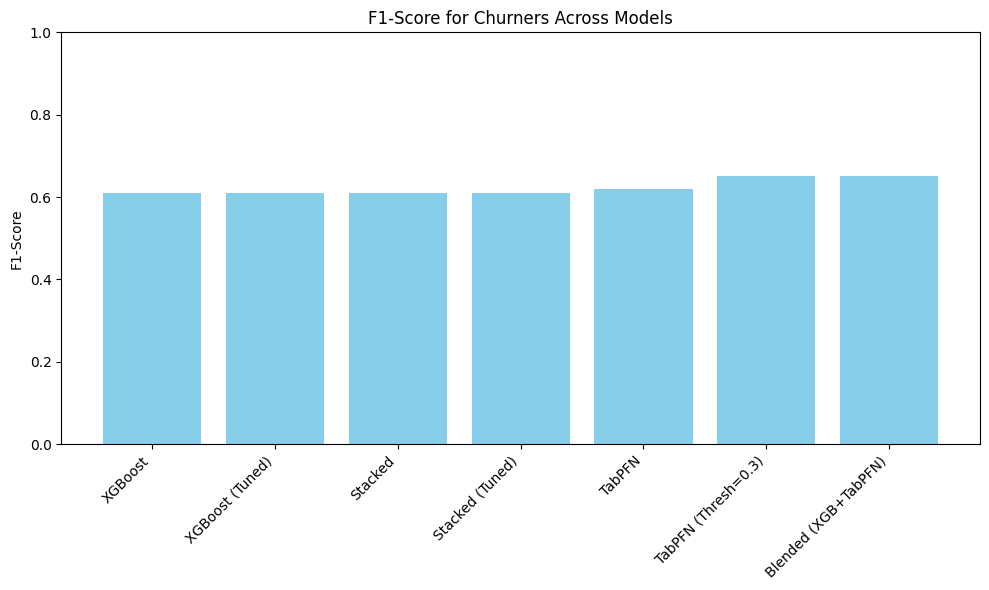

In [ ]:
#F1 SCORE COMPARISON CHART
plt.figure(figsize=(10,6))
plt.bar(model_results['Model'], model_results['F1_Churn'], color='skyblue')
plt.title('F1-Score for Churners Across Models')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
# Putting all model results in a dataframe
model_results = pd.DataFrame({
    'Model': [
        'XGBoost',
        'XGBoost (Tuned)',
        'Stacked',
        'Stacked (Tuned)',
        'TabPFN',
        'TabPFN (Thresh=0.3)',
        'Blended (XGB+TabPFN)'
    ],
    'Accuracy': [0.82, 0.82, 0.86, 0.85, 0.871, 0.854, 0.852],
    'Precision_Churn': [0.55, 0.54, 0.69, 0.66, 0.78, 0.64, 0.63],
    'Recall_Churn': [0.68, 0.71, 0.55, 0.57, 0.51, 0.65, 0.66],
    'F1_Churn': [0.61, 0.61, 0.61, 0.61, 0.62, 0.65, 0.65]
})

In [ ]:
#DEFINE CUSTOM WEIGHTS
# Set your preferred weights
f1_w = 0.5           # Emphasize balanced performance
recall_w = 0.3       # Emphasize finding churners
precision_w = 0.2    # Still care about precision

In [ ]:
#CALCULATE THE WEIGHTED SCORE
# Apply the weighted formula
model_results["Weighted_Score"] = (
    f1_w * model_results["F1_Churn"] +
    recall_w * model_results["Recall_Churn"] +
    precision_w * model_results["Precision_Churn"]
)

In [ ]:
#SORT AND DISPLAY FINAL TABLE
# Sort by weighted score
model_results_sorted = model_results.sort_values(by="Weighted_Score", ascending=False).reset_index(drop=True)

# Display the result
print(model_results_sorted)

                  Model  Accuracy  Precision_Churn  Recall_Churn  F1_Churn  \
0  Blended (XGB+TabPFN)     0.852             0.63          0.66      0.65   
1   TabPFN (Thresh=0.3)     0.854             0.64          0.65      0.65   
2       XGBoost (Tuned)     0.820             0.54          0.71      0.61   
3                TabPFN     0.871             0.78          0.51      0.62   
4               XGBoost     0.820             0.55          0.68      0.61   
5               Stacked     0.860             0.69          0.55      0.61   
6       Stacked (Tuned)     0.850             0.66          0.57      0.61   

   Weighted_Score  
0           0.649  
1           0.648  
2           0.626  
3           0.619  
4           0.619  
5           0.608  
6           0.608  


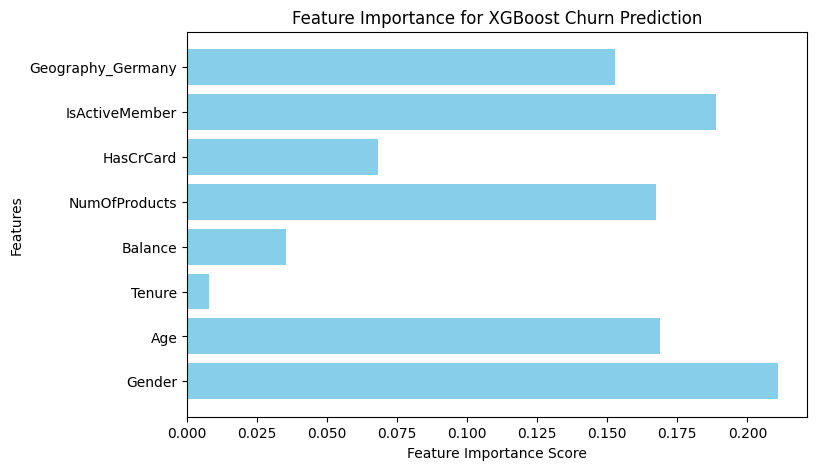

In [ ]:
# Get feature importance from XGBoost
importance = best_xgb_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(8,5))
plt.barh(selected_features, importance, color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance for XGBoost Churn Prediction")
plt.show()

In [ ]:
import shap

 94%|=================== | 1875/2000 [00:11<00:00]       

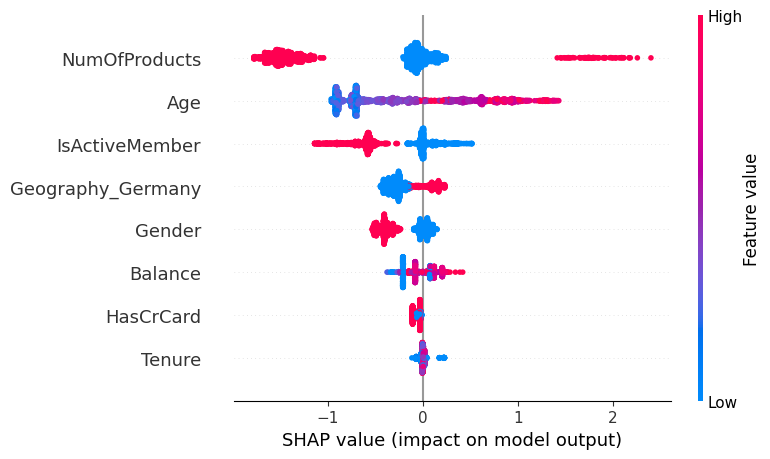

In [ ]:
#Initialize the SHAP explainer for XGBoost
explainer = shap.Explainer(best_xgb_model, A_train_smote)

#Generate SHAP values on the test set
shap_values = explainer(A_test)

#Summary plot (global feature importance)
shap.summary_plot(shap_values, A_test, feature_names=selected_features)

In [ ]:
#SAVING BEST MODEL
import joblib

# Putting xgboost and tabpfn models in a dataframe
models = {
    'xgboost': xgbmodel3,
    'tabpfn': tabpfnmodel2
}

# Save to disk
joblib.dump(models, 'blended_models.pkl')

print("✅ Models saved successfully as 'blended_models.pkl'")

✅ Models saved successfully as 'blended_models.pkl'
